In [1]:
import os
import pandas as pd
import numpy as np
import math
from IPython.core.debugger import Tracer
import warnings
warnings.filterwarnings("ignore")

LEFT = "LEFT" #0
RIGHT = "RIGHT" #1
UP = "UP" #2
DOWN = "DOWN" #3
MOVES = [LEFT, RIGHT, UP, DOWN]
MOVE = {LEFT : (0, -1), RIGHT : (0, 1), UP : (-1, 0), DOWN : (1, 0)}
CURRENT_CELL = 1
BLOCKED_CELL = -1
EMPTY_CELL = 0
GRID_SIZE = 6
N_CLASSES = 4

LEARNING_RATE = 0.075
Q_DISCOUNT_FACTOR = 0.8
Q_LEARNING_RATE = 0.75
Q_EXPLORATION_PROBABILITY = 0.7

REWARD_DEPRATION_RATE = 0.9
REWARD_FACTOR = 5

In [2]:
from sklearn.utils.extmath import softmax
def softmaxify(arr):
    if np.min(arr) < 0:
        return softmax(np.add(arr, -1 * np.min(arr)))
    
    return softmax(arr)

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import LabelBinarizer
import keras.backend as K

model = None
BATCH_SIZE = 1
FEATURE_SIZE = GRID_SIZE * GRID_SIZE
n_classes = N_CLASSES
EPOCHS = 100


def customLoss(yTrue,yPred):
    return K.sum(K.abs(yTrue - yPred))


def get_features(grid):
    return np.int32([grid.flatten()])

def search_grid(grid, val):
    loc = np.where(grid == val)
    return (loc[0][0], loc[1][0])


def validate_move(grid, current_loc, move):
    grid = grid.copy()
    next_loc = (current_loc[0] + move[0], current_loc[1] + move[1])
    
    if next_loc[0] < 0 or next_loc[1] < 0 or next_loc[0] == len(grid) or next_loc[1] == len(grid):
        return False, current_loc, grid
    
    if grid[next_loc[0]][next_loc[1]] != EMPTY_CELL:
        return False, current_loc, grid
    
    grid[current_loc[0]][current_loc[1]] = BLOCKED_CELL
    grid[next_loc[0]][next_loc[1]] = CURRENT_CELL
    return True, next_loc, grid


def get_model(feature_size=FEATURE_SIZE):
    model = Sequential()
    model.add(Dense(4096, activation=LeakyReLU(), input_shape=(feature_size,)))
    #model.add(Dropout(0.3))
    #model.add(Dense(2048, activation=LeakyReLU()))
    #model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation=LeakyReLU()))
    #model.summary()

    model.compile(loss='mean_squared_error',
        optimizer=Adam(lr=LEARNING_RATE),
        metrics=[customLoss])

    return model


def train_model(features, labels, model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0):
    history = model.fit(features, labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_data=(features, labels))

    score = model.evaluate(features, labels, verbose=verbose)
    if verbose != 0:
        print('Loss:', score[0])
        
    return model
    
    
def predict(features, model, verbose=0):
    return model.predict(features, verbose=0)
    

Using TensorFlow backend.


In [4]:
def initialize_grid(grid_size=GRID_SIZE, current_cell=(1,0), blocked_cells=[(0,0),(0,GRID_SIZE - 1)]):
    grid = np.full((grid_size, grid_size), EMPTY_CELL, dtype=np.int32)
    
    for blocked_cell in blocked_cells:
        grid[blocked_cell[0]][blocked_cell[1]] = BLOCKED_CELL

    grid[current_cell[0]][current_cell[1]] = CURRENT_CELL
    return grid


def is_game_over(grid):
    if is_game_won(grid):
        return True
    
    valid_move = False
    for possible_movement in MOVES:
        possible_move = MOVE[possible_movement]
        move_validity, _, _ = validate_move(grid=grid, 
                                                   current_loc=search_grid(grid=grid, 
                                                                           val=CURRENT_CELL), move=possible_move)
        valid_move = valid_move or move_validity
        
    return not valid_move


def fetch_n_empty_cells(grid):
    return (grid == EMPTY_CELL).sum()


def fetch_n_non_empty_cells(grid):
    n_empty_cells = fetch_n_empty_cells(grid)
    return np.size(grid) - n_empty_cells


def fetch_n_blocked_cells(grid):
    return (grid == BLOCKED_CELL).sum()


def is_game_won(grid):
    if not np.any(grid == EMPTY_CELL):
        return True

    return False


def get_next_moves_score(grid, model):
    f = get_features(grid)
    return predict(features=f, model=model)


def calculate_reward(grid, game_gain, move_number):
    game_factor = game_gain / 100
    move_factor = REWARD_DEPRATION_RATE ** (np.size(grid) - move_number)
    
    reward = move_factor * game_factor * (REWARD_FACTOR ** (np.int16(game_gain / 25)))
    
    #reward = 1 - (fetch_n_empty_cells(grid) - 1) / fetch_n_empty_cells(grid) 
    #reward = REWARD_FACTOR * reward * reward
    return reward 


def get_target_q_value(grid, next_grid, model, q_value, reward):
    next_max_q_value = np.max(get_next_moves_score(next_grid.copy(), model))  
    if is_game_over(next_grid):
        target_q_factor = Q_LEARNING_RATE * (REWARD_FACTOR - q_value)
    else:
        target_q_factor = Q_LEARNING_RATE * (reward - q_value + Q_DISCOUNT_FACTOR * next_max_q_value)
    
    return q_value +  target_q_factor
                         
                              
def play_game(gameid, grid, model, n_play_moves=0, game_number_ratio=Q_EXPLORATION_PROBABILITY, verbose=True):
    valid_move = False
    game_over = False
    total_moves = 0
    valid_moves_count = 0
    invalid_moves_count = 0
    experiences = []

    while not game_over:
        valid_move = False
        
        while not valid_move:
            total_moves = total_moves + 1
            
            probable_moves = []
            f = get_features(grid)
            moves_score = get_next_moves_score(grid, model)
            move = np.argmax(moves_score)
            rand_move = np.random.randint(N_CLASSES)
            probable_moves.append(move)
            probable_moves.append(rand_move)
            move = probable_moves[np.random.choice(2, p=[game_number_ratio, 1 - game_number_ratio])]
            #print(f, moves_score, MOVES[move])
            
            valid_move, next_loc, next_grid = validate_move(grid=grid, 
                                                       current_loc=search_grid(grid=grid, 
                                                                               val=CURRENT_CELL), move=MOVE[MOVES[move]])

            if not valid_move:
                if verbose:
                    print("Punishing...")
                    
                moves_score[0][move] = np.min(moves_score) - 0.1
                train_model(features=f, labels=moves_score, model=model, epochs=EPOCHS, batch_size=1)
                invalid_moves_count = invalid_moves_count + 1
                continue

            
            experiences.append((grid, next_grid, move, moves_score))
            grid = next_grid
            valid_moves_count = valid_moves_count + 1
            moves_score = get_next_moves_score(grid, model)
            move = np.argmax(moves_score)
            if n_play_moves > 0 and valid_moves_count == n_play_moves:
                game_over = True
                break

        game_over = game_over or is_game_over(grid)
        valid_move = False # reset flag for next move
        
        
    if verbose:
        print("Rewarding...")  
          
    gain = fetch_n_non_empty_cells(grid) / np.size(grid)
    gain = gain * gain * 100
        
    game_won = is_game_won(grid=grid)
    features = []
    labels = []
    move_counter = 1
    for experience in experiences:
        state = experience[0]
        next_state = experience[1]
        move = experience[2]
        moves_score = np.array(experience[3])
        reward = calculate_reward(grid=state,game_gain=gain, move_number=move_counter)
        moves_score[0][move] = get_target_q_value(state, next_state, model, moves_score[0][move], reward)
        if game_won:
            moves_score[0][move] = moves_score[0][move] + 0
            
        f = np.array(get_features(state))
        if len(features) == 0:
            features = f
            labels = moves_score
            
        else:
            features = np.concatenate((features, f), axis=0)
            labels = np.concatenate((labels, moves_score), axis=0)
            
        move_counter = move_counter + 1
            
    
    train_model(features=features, labels=labels, epochs=EPOCHS, model=model, batch_size=len(features), verbose=0)
    print("Game Played: ", gameid)
    print("Gain: ", gain)
    print("GRID: \n", grid, "\n\n")
    return grid, model, total_moves, valid_moves_count, invalid_moves_count, gain
    

In [5]:
model = None

In [6]:
import matplotlib.pyplot as plt

grid_size=4
blocked_cells=[(0,0),(0,3),(2,2)]
current_cell=(1,0)

x = []
n_total_moves = []
n_valid_moves_count = []
n_invalid_moves_count = []
n_game_gains = []
n_games_to_be_played = 100

if model == None:
    model = get_model(feature_size=grid_size * grid_size)
    
for n_game in range(n_games_to_be_played):
    GRID = initialize_grid(grid_size=grid_size, blocked_cells=blocked_cells, current_cell=current_cell)
    game_number_ratio = Q_EXPLORATION_PROBABILITY
    if n_game > (n_games_to_be_played / 2):
        game_number_ratio = 1
        
    #game_number_ratio = game_number_ratio * game_number_ratio
    GRID, model, total_moves, valid_moves_count, invalid_moves_count, gain = play_game(gameid=n_game+1, grid=GRID, model=model, verbose=False, game_number_ratio=game_number_ratio)
    x.append(n_game + 1)
    n_total_moves.append(total_moves)
    n_valid_moves_count.append(valid_moves_count)
    n_invalid_moves_count.append(invalid_moves_count)
    n_game_gains.append(gain)

Game Played:  1
Gain:  56.25
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [-1 -1 -1  0]
 [-1 -1  0  0]] 


Game Played:  2
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1  1 -1 -1]
 [-1 -1 -1 -1]] 


Game Played:  3
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1  1 -1]] 


Game Played:  4
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1 -1 -1 -1]] 


Game Played:  5
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1 -1 -1 -1]] 


Game Played:  6
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1 -1 -1 -1]] 


Game Played:  7
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1  1 -1]] 


Game Played:  8
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1  1 -1 -1]
 [-1 -1 -1 -1]] 


Game Played:  9
Gain:  100.0
GRID: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1 -1 -1 -1]] 


Game Played:  10
Gain:  76.5625
GRID: 
 [[-1  0  0 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1 -

Game Played:  82
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  83
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  84
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  85
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  86
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  87
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  88
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  89
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  90
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  0  0]] 


Game Played:  91
Gain:  25.0
GRID: 
 [[-1  1 -1 -1]
 [-1 -1 -1  0]
 [ 0  0 -1  0]
 [ 0  0  

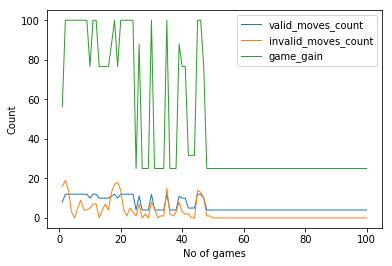

In [7]:
import matplotlib.pyplot as plt
plt.xlabel('No of games')
plt.ylabel('Count')
#plt.plot(x, n_total_moves, linewidth=1, label="total_moves")
plt.plot(x, n_valid_moves_count, linewidth=1, label="valid_moves_count")
plt.plot(x, n_invalid_moves_count, linewidth=1, label="invalid_moves_count")
plt.plot(x, n_game_gains, linewidth=1, label="game_gain")
plt.legend(loc="bottom right")
plt.show()

In [8]:
grid_size=4
blocked_cells=[(0,0),(0,3),(2,2)]
current_cell=(1,0)

initialize_grid(grid_size=grid_size, blocked_cells=blocked_cells, current_cell=current_cell)

array([[-1,  0,  0, -1],
       [ 1,  0,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0,  0]], dtype=int32)